### 1 - Import test data

In [29]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("EURUSD_Candlestick_5_M_BID_01.02.2023-17.02.2024.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df=df[df.High!=df.Low]
df.set_index("Gmt time", inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'EURUSD_Candlestick_5_M_BID_01.02.2023-17.02.2024.csv'

In [30]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from binance.client import Client

client = Client()

# Fetch historical klines
df = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, "5 day ago UTC")
columns = [
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume1',
    'Close time', 'Volume', 'Adj Close',
    'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
]
df = pd.DataFrame(df, columns=columns)

# Drop unnecessary columns
df = df.drop(['Close time', 'Volume1', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], axis='columns')

# Convert columns to numeric
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')

# Convert 'Open time' to datetime and set it as the index
df['Datetime'] = pd.to_datetime(df['Open time'], unit='ms')
df = df.drop(['Open time'], axis='columns')
df.set_index('Datetime', inplace=True)
df.index = df.index.tz_localize('UTC')

# Now you can safely calculate the EMA and ATR
df["EMA_slow"] = ta.ema(df['Close'], length=50)
df["EMA_fast"] = ta.ema(df['Close'], length=40)
df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=7)

df = df[51:]
df

,Open,High,Low,Close,Volume,Adj Close,EMA_slow,EMA_fast,ATR
Datetime,,,,,,,,,
2024-09-02 05:47:00+00:00,57854.00,57870.88,57851.10,57851.12,2.884782e+05,640,57631.115245,57676.723574,33.770159
2024-09-02 05:48:00+00:00,57851.12,57870.00,57824.00,57824.01,1.045168e+06,1151,57638.679745,57683.908278,35.517856
2024-09-02 05:49:00+00:00,57824.01,57831.00,57797.10,57797.11,4.074741e+05,1009,57644.892696,57689.430313,35.286668
2024-09-02 05:50:00+00:00,57797.10,57812.00,57787.87,57799.00,2.019453e+06,1603,57650.936120,57694.775176,33.692472
2024-09-02 05:51:00+00:00,57799.00,57834.00,57798.99,57833.99,5.526362e+05,1071,57658.114703,57701.566143,33.880729
...,...,...,...,...,...,...,...,...,...
2024-09-07 04:51:00+00:00,53987.30,53993.67,53987.29,53993.66,2.022913e+05,423,53897.927732,53907.639482,11.591071
2024-09-07 04:52:00+00:00,53993.66,53999.99,53989.47,53998.80,3.930047e+05,926,53901.883508,53912.086337,11.438061
2024-09-07 04:53:00+00:00,53999.98,54037.00,53999.98,54033.17,1.175003e+06,1417,53907.031997,53917.992857,15.261195


In [31]:
df['RSI']=ta.rsi(df.Close, length=10)
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)
df=df.join(my_bbands)

In [32]:
def bollinger_signal(df):
    condition_buy = df['Close'] <= df['BBL_15_1.5']
    condition_sell = df['Close'] >= df['BBU_15_1.5']

    df['bollinger_Signal'] = 0  # Default no signal
    df.loc[condition_buy, 'bollinger_Signal'] = 2
    df.loc[condition_sell, 'bollinger_Signal'] = 1
bollinger_signal(df)

In [33]:
import numpy as np
def calculate_rsi_signal_windowed(rsi_series):
    rsi_signal = np.zeros(len(rsi_series))
    for i in range(len(rsi_series)):
        window_start = max(0, i - 5)  # Adjusting to the correct window size
        window = rsi_series[window_start:i]  # Excludes the current value, as intended
        # Apply conditions within the window
        if not window.empty and window.gt(50.1).all():
            rsi_signal[i] = 2
        elif not window.empty and window.lt(49.9).all():
            rsi_signal[i] = 1
        # Else, it remains 0
    return rsi_signal

# Apply the function to calculate RSI_signal
df['RSI_signal'] = calculate_rsi_signal_windowed(df['RSI'])
df['TotalSignal'] = df.apply(lambda row: row['bollinger_Signal'] if row['bollinger_Signal'] == row['RSI_signal'] else 0, axis=1)

In [34]:
df.TotalSignal.value_counts()

TotalSignal
0.0    7090
1.0      33
2.0      26
Name: count, dtype: int64

In [35]:
import numpy as np
def pointpos(x):
    if x['TotalSignal']==2:
        return x['Low']-1e-4
    elif x['TotalSignal']==1:
        return x['High']+1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),

                go.Scatter(x=dfpl.index, y=dfpl['BBL_15_1.5'], 
                           line=dict(color='green', width=1), 
                           name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_15_1.5'], 
                           line=dict(color='green', width=1), 
                           name="BBU")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=8, color="MediumPurple"),
                name="entry")
fig.update_layout(width=1200, height=800)
fig.show(renderer="browser")

## Fixed Size Lot/Trade

In [37]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[:]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 3000 #MT4 0.03 lot
    slcoef = 1.1
    TPSLRatio = 1.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=2500000, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/backtesting/backtesting.py:1384: FutureWarning:

The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



Start                     2024-09-02 05:47...
End                       2024-09-07 04:55...
Duration                      4 days 23:08:00
Exposure Time [%]                         0.0
Equity Final [$]                    2500000.0
Equity Peak [$]                     2500000.0
Return [%]                                0.0
Buy & Hold Return [%]               -6.598161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [38]:
stats["_strategy"]

<Strategy MyStrat(slcoef=1.0,TPSLRatio=1.0)>

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning:

All-NaN slice encountered

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning:

All-NaN slice encountered



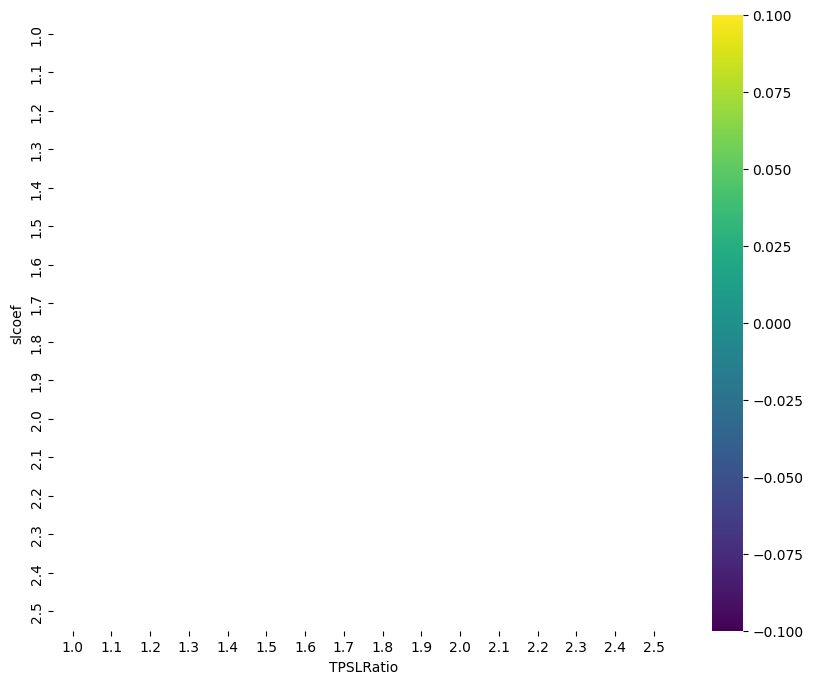

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

## Equity percentage Lot/Trade size

In [40]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[:]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 0.3 # 3000 previous fixed value
    slcoef = 1.1
    TPSLRatio = 1.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=250000, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

Backtest.optimize:   0%|          | 0/13 [00:00<?, ?it/s]/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/backtesting/_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/backtesting/_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/backtesting/_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/backtesting/_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/backtesting/_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/backtesting/_stats.py:122: RuntimeWarning:

divide by zero encountered in scalar divide

/home/nitin/Downloa

Start                     2024-09-02 05:47...
End                       2024-09-07 04:55...
Duration                      4 days 23:08:00
Exposure Time [%]                   20.870052
Equity Final [$]                324530.167569
Equity Peak [$]                 324530.167569
Return [%]                          29.812067
Buy & Hold Return [%]               -6.598161
Return (Ann.) [%]              2254322.688494
Volatility (Ann.) [%]          1127539.473392
Sharpe Ratio                         1.999329
Sortino Ratio                             inf
Calmar Ratio                    166164.711131
Max. Drawdown [%]                  -13.566796
Avg. Drawdown [%]                   -1.815791
Max. Drawdown Duration        1 days 02:24:00
Avg. Drawdown Duration        0 days 02:32:00
# Trades                                   48
Win Rate [%]                        39.583333
Best Trade [%]                       1.299763
Worst Trade [%]                     -0.625461
Avg. Trade [%]                    

## Risk related Lot/Trade size

In [43]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[:]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    risk_perc = 0.05
    slcoef = 1.1
    TPSLRatio = 1.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()

        # Calculate Stop Loss ATR
        slatr = self.slcoef * self.data.ATR[-1]

        # Check if slatr is NaN or zero
        if not slatr or np.isnan(slatr):
            return  # Skip this iteration if ATR can't be computed

        # Lot sizing considering risk
        pip_value = (1e-4 / self.data.Close[-1]) * 1e5

        # Check if pip_value is valid
        if pip_value == 0 or np.isnan(pip_value):
            return  # Skip this iteration if pip_value is invalid

        # Calculate the lot size
        size = int(self.risk_perc * self.equity / (slatr * pip_value))

        # Trading logic
        if self.signal1 == 2 and len(self.trades) == 0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr * self.TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=size)

        elif self.signal1 == 1 and len(self.trades) == 0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr * self.TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=size)

bt = Backtest(dfopt, MyStrat, cash=250000, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/backtesting/backtesting.py:1384: FutureWarning:

The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



Start                     2024-09-02 05:47...
End                       2024-09-07 04:55...
Duration                      4 days 23:08:00
Exposure Time [%]                         0.0
Equity Final [$]                     250000.0
Equity Peak [$]                      250000.0
Return [%]                                0.0
Buy & Hold Return [%]               -6.598161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

Let's say, for example, you are trading 1 standard lot of EUR/USD and the exchange rate is 1.2000:

- One Pip = 0.0001
- Exchange Rate = 1.2000
- Lot Size = 100,000
- Pip value = (0.0001 / 1.2000) * 100,000
- Pip value = $8.33

So, for every pip movement in the EUR/USD currency pair, the value would be $8.33

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning:

All-NaN slice encountered

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning:

All-NaN slice encountered



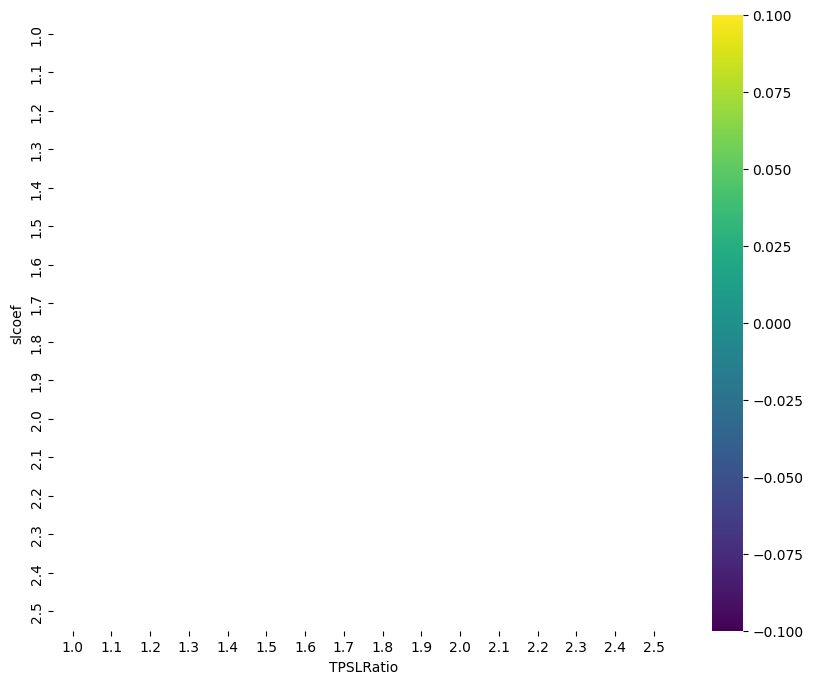

In [44]:
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [45]:
bt.plot()

ValueError: failed to validate DatetimeTickFormatter(id='p1046', ...).days: expected a value of type str, got ['%d %b', '%a %d'] of type list

In [46]:
stats._strategy

<Strategy MyStrat(slcoef=1.0,TPSLRatio=1.0)>